In [1]:
from PIL import Image, ImageStat
import numpy
import glob, os
import scipy.misc
from matplotlib import pyplot

%matplotlib inline

import scipy as sp
import pylab as pl
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import KMeans
from skimage.io import imread

In [2]:
def converged(centroids, old_centroids):
	if len(old_centroids) == 0:
		return False


	if len(centroids) <= 5:
		a = 1
	elif len(centroids) <= 10:
		a = 2
	else:
		a = 4

	for i in range(0, len(centroids)):
		cent = centroids[i]
		old_cent = old_centroids[i]

		if ((int(old_cent[0]) - a) <= cent[0] <= (int(old_cent[0]) + a)) and ((int(old_cent[1]) - a) <= cent[1] <= (int(old_cent[1]) + a)) and ((int(old_cent[2]) - a) <= cent[2] <= (int(old_cent[2]) + a)):
			continue
		else:
			return False

	return True

In [3]:
def getMin(pixel, centroids):
	minDist = 9999
	minIndex = 0

	for i in range(0, len(centroids)):
		d = numpy.sqrt(int((centroids[i][0] - pixel[0]))**2 + int((centroids[i][1] - pixel[1]))**2 + int((centroids[i][2] - pixel[2]))**2)
		if d < minDist:
			minDist = d
			minIndex = i

	return minIndex

In [4]:
def assignPixels(centroids):
	clusters = {}

	for x in range(0, img_width):
		for y in range(0, img_height):
			p = px[x, y]
			minIndex = getMin(px[x, y], centroids)

			try:
				clusters[minIndex].append(p)
			except KeyError:
				clusters[minIndex] = [p]

	return clusters

In [5]:
def adjustCentroids(centroids, clusters):
	new_centroids = []
	keys = sorted(clusters.keys())
	#print(keys)

	for k in keys:
		n = numpy.mean(clusters[k], axis=0)
		new = (int(n[0]), int(n[1]), int(n[2]))
		print(str(k) + ": " + str(new))
		new_centroids.append(new)

	return new_centroids

In [6]:
def startKmeans(someK):
	centroids = []
	old_centroids = []
	rgb_range = ImageStat.Stat(im).extrema
	i = 1

	#Initializes someK number of centroids for the clustering
	for k in range(0, someK):

		cent = px[numpy.random.randint(0, img_width), numpy.random.randint(0, img_height)]
		centroids.append(cent)
	

	print("Centroids Initialized. Starting Assignments")
	print("===========================================")

	while not converged(centroids, old_centroids) and i <= 20:
		print("Iteration #" + str(i))
		i += 1

		old_centroids = centroids 								#Make the current centroids into the old centroids
		clusters = assignPixels(centroids) 						#Assign each pixel in the image to their respective centroids
		centroids = adjustCentroids(old_centroids, clusters) 	#Adjust the centroids to the center of their assigned pixels


	print("===========================================")
	print("Convergence Reached!")
	print(centroids)
	return centroids

#end startKmeans

In [7]:
def drawWindow(result):
	img = Image.new('RGB', (img_width, img_height), "white")
	p = img.load()

	for x in range(img.size[0]):
		for y in range(img.size[1]):
			RGB_value = result[getMin(px[x, y], result)]
			p[x, y] = RGB_value

	img.show(); img.save('tmp.png')

In [8]:
k_input = int(input("Enter K value: "))

Enter K value: 3


In [9]:
im = Image.open('/Users/anmolukhare/Downloads/justice_league_poster_final_approved.jpeg')
#im = Image.open(img)
img_width, img_height = im.size
px = im.load()

In [10]:
result = startKmeans(k_input)
drawWindow(result)

Centroids Initialized. Starting Assignments
Iteration #1
0: (251, 238, 224)
1: (89, 42, 36)
2: (2, 1, 2)
Iteration #2
0: (252, 242, 229)
1: (129, 63, 49)
2: (5, 3, 3)
Iteration #3
0: (253, 247, 237)
1: (165, 87, 60)
2: (9, 4, 5)
Iteration #4
0: (253, 250, 243)
1: (191, 109, 69)
2: (12, 6, 7)
Iteration #5
0: (253, 252, 247)
1: (205, 124, 76)
2: (14, 7, 8)
Iteration #6
0: (254, 253, 249)
1: (213, 133, 82)
2: (16, 7, 8)
Iteration #7
0: (254, 253, 250)
1: (216, 138, 84)
2: (17, 8, 9)
Iteration #8
0: (254, 253, 250)
1: (217, 139, 85)
2: (17, 8, 9)
Convergence Reached!
[(254, 253, 250), (217, 139, 85), (17, 8, 9)]


## GMM

In [11]:
img = Image.open('/Users/anmolukhare/Downloads/justice_league_poster_final_approved.jpeg').resize((480,320), Image.ANTIALIAS)
pixels = numpy.asarray(((img.getdata())))

In [12]:
N = 153600

In [13]:
feat = pixels
v = [0,1,2]
val = 250
mean = [numpy.array([120, 120, 120]), numpy.array([12, 12, 12]), numpy.array([180, 180, 180])]
var = [val*numpy.identity(3), val*numpy.identity(3), val*numpy.identity(3)]

In [14]:
weights = [float(1/3), float(1/3), float(1/3)]

In [15]:
def gau(mean, var, varInv, feature):
	a = numpy.sqrt(2*numpy.pi**3)
	b = numpy.exp(-0.5*numpy.dot((feature-mean), numpy.dot(varInv, (feature-mean).transpose())))
	return b/a

In [16]:
def res(likelihoods):
	tempList = []
	for comp in likelihoods:
		tempList.append(comp/sum(likelihoods))
	return tempList

In [17]:
def likeli(mean, var, varInv, weights, feature):
	temp = []
	for x in v:
		temp.append(weights[x]*gau(mean[x], var[x], varInv[x], feature))
	return temp

In [18]:
varInv = [numpy.linalg.inv(var[0]), numpy.linalg.inv(var[1]), numpy.linalg.inv(var[2])]
meanPrev = [numpy.array([0, 0, 0]), numpy.array([0, 0, 0]), numpy.array([0, 0, 0])]
iteration = []
logLikelihoods = []
counterr = 0

In [19]:
while sum(sum(numpy.absolute(numpy.asarray(mean) - numpy.asarray(meanPrev)))) >= 3:
	resp = []
	likelihoods = []
	for feature in feat:
		classLikelihoods = likeli(mean, var, varInv, weights, feature)
		rspblts = res(classLikelihoods)
		likelihoods.append(sum(classLikelihoods))
		resp.append(rspblts)
	logLikelihoods.append(sum(numpy.log(likelihoods)))
	nK = [sum(numpy.asarray(resp)[:,0:1]), sum(numpy.asarray(resp)[:,1:2]), sum(numpy.asarray(resp)[:,2:3])]
	weights = [float(nK[0]/N), float(nK[1]/N), float(nK[2]/N)]
	meanIterator =  numpy.dot(numpy.asarray(resp).T, feat)
	meanPrev = mean
	mean = [meanIterator[0]/nK[0], meanIterator[1]/nK[1], meanIterator[2]/nK[2]]
	counterr += 1
	iteration.append(counterr)

In [20]:
resp = []
for feature in feat:
	classLikelihoods = likeli(mean, var, varInv, weights, feature)
	rspblts = res(classLikelihoods)
	resp.append(rspblts)
	
result = []
counter = 0
segmentedImage = numpy.zeros((N, numpy.shape(img)[2]), numpy.uint8)

In [21]:
for response in resp:
    maxResp = max(response)
    respmax = response.index(maxResp)
    result.append(respmax)
    segmentedImage[counter] = mean[respmax]
    counter = counter + 1

In [22]:
blue0 = segmentedImage[:,0]
green0 = segmentedImage[:,1]
red0 = segmentedImage[:,2]

In [23]:
blue = numpy.reshape(blue0.flatten(), (numpy.shape(img)[0],numpy.shape(img)[1]))
green = numpy.reshape(green0.flatten(), (numpy.shape(img)[0],numpy.shape(img)[1]))
red = numpy.reshape(red0.flatten(), (numpy.shape(img)[0],numpy.shape(img)[1]))

In [24]:
recns = numpy.zeros((320, 480, 3))

In [25]:
for i in range(320):
	for j in range(480):
		recns[i][j] = numpy.array([blue[i][j], green[i][j], red[i][j]])

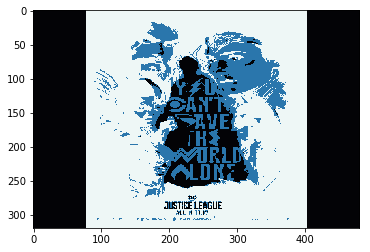

In [26]:
pyplot.imshow(recns)
pyplot.show()

Text(0.5,0,'Iteration number')

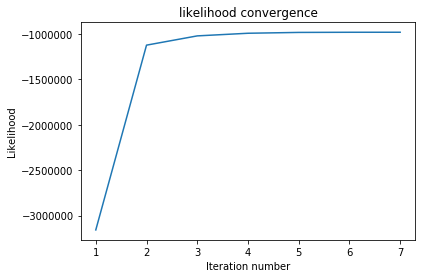

In [27]:
pyplot.plot(iteration, logLikelihoods)
pyplot.title('likelihood convergence')
pyplot.ylabel('Likelihood')
pyplot.xlabel('Iteration number')